# ML Summer School - Assignment 4

In this assignment, we will be clustering movies on the basis of their synopsis. Unlike previous assignments, this time you will be implementing the KMeans clustering algorithm from scratch.

### Load Libraries

In [111]:
import numpy as np
import pandas as pd
import nltk
import re
import os
from sklearn import feature_extraction
import pickle
import scipy
from nltk.stem.lancaster import LancasterStemmer

### Load data
We will be using the synopsis of Top 100 movies ranked by IMDb. `titles`, `genres` and `synopsis` are lists stored as pickled files. We first load them into memory. 

Take a look at the lists we have just loaded.

In [112]:
titles = pickle.load(open('data/titles.pkl','rb'))
genres = pickle.load(open('data/genres.pkl','rb'))
synopsis = pickle.load(open('data/synopses.pkl','rb'))
print(len(titles), len(genres), len(synopsis))

100 100 100


### Preprocessing the Data

Let us take a look at some of the synopsis.

In [113]:
print(synopsis[0])

 Plot  [edit]  [  [  edit  edit  ]  ]  
  On the day of his only daughter's wedding, Vito Corleone hears requests in his role as the Godfather, the Don of a New York crime family. Vito's youngest son, Michael, in a Marine Corps uniform, introduces his girlfriend, Kay Adams, to his family at the sprawling reception. Vito's godson Johnny Fontane, a popular singer, pleads for help in securing a coveted movie role, so Vito dispatches his consigliere, Tom Hagen, to Los Angeles to influence the abrasive studio head, Jack Woltz. Woltz is unmoved until the morning he wakes up in bed with the severed head of his prized stallion.  On the day of his only daughter's wedding,   Vito Corleone  Vito Corleone   hears requests in his role as the Godfather, the   Don  Don   of a New York crime family. Vito's youngest son,   Michael  Michael  , in a   Marine Corps  Marine Corps   uniform, introduces his girlfriend,   Kay Adams  Kay Adams  , to his family at the sprawling reception. Vito's godson   Johnny

In [114]:
print(synopsis[1])

 Plot  [edit]  [  [  edit  edit  ]  ]  
  In 1947, banker Andy Dufresne is convicted of murdering his wife and her lover and sentenced to two consecutive life sentences at the fictional Shawshank State Penitentiary in the state of Maine. Andy befriends contraband smuggler Ellis "Red" Redding, an inmate serving a life sentence. Red procures a rock hammer and later a large poster of Rita Hayworth for Andy. Working in the prison laundry, Andy is regularly assaulted by the "bull queer" gang "the Sisters" and their leader, Bogs.  In 1947, banker Andy Dufresne is convicted of murdering his wife and her lover and sentenced to two consecutive life sentences at the fictional Shawshank State Penitentiary in the state of Maine. Andy befriends   contraband  contraband   smuggler Ellis "Red" Redding, an inmate serving a life sentence. Red procures a   rock hammer  rock hammer   and later a large poster of   Rita Hayworth  Rita Hayworth   for Andy. Working in the prison laundry, Andy is regularly as

We can see that the synopsis contain a lot of names (Proper Nouns) and years. They are specific to the movies and do not seem to be helpful to cluster the movies. We should remove them

We will also be lemmatizing the words. [Lemmatizing](https://www.twinword.com/blog/what-is-lemmatization/ ) refers to replacing word by its base form (lemma). For example, lemmatizing `cars` gives `car`. Lemmatizing will help in clubbing all different inflections of words, eg. `loves`, `loving`, `loved` will all be lemmatized to `love`.

### Task 1

Complete the following function `preprocess_data`. It takes in text as input, and [removes proper nouns](https://stackoverflow.com/questions/39634222/is-there-a-way-to-remove-proper-nouns-from-a-sentence-using-python), non-alphabetic words, lemmatizes the data and lower cases the entire text.

In [134]:
from nltk.stem import WordNetLemmatizer
lem=WordNetLemmatizer()
import random

In [135]:
def preprocess_data(text):
    """Removes proper noun, non-alphabetic words, lemmatizes the data and lower cases the entire text"""
    
    # YOUR CODE STARTS HERE
    tagged_sentence = nltk.tag.pos_tag(text.split())
    text = [word for word,tag in tagged_sentence if tag != 'NNP' and tag != 'NNPS' ]
    text=[lem.lemmatize(word) for word in text]
    text = ' '.join(text)
    text = re.sub(r'([^\s\w]|_)+', '', text) 
    text = text.lower()
    # YOUR CODE ENDS HERE
    
    return text

**Sample input**: preprocess_data(synopsis[0][:1000])


**Sample output**: 'edit edit edit day daughter wedding hears request role crime family son uniform introduces girlfriend family reception godson singer pleads help securing movie role dispatch consigliere influence studio head is unmoved morning wake bed head stallion day daughter wedding hears request role crime family son uniform introduces girlfriend family reception godson'



In [136]:
preprocess_data(synopsis[0][:1000])

'edit edit  on the day of his only daughters wedding hears request in his role a the the of a crime family youngest son in a uniform introduces his girlfriend to his family at the sprawling reception godson a popular singer pleads for help in securing a coveted movie role so dispatch his consigliere to to influence the abrasive studio head is unmoved until the morning he wake up in bed with the severed head of his prized stallion on the day of his only daughters wedding hears request in his role a the the of a crime family youngest son  in a uniform introduces his girlfriend  to his family at the sprawling reception godson'

### Creating the Features

We will extract features from the synopsis using TfIdf Vectoriser, which will be used to cluster the movies. 

Read more about TfIdf Vectoriser [here](http://blog.christianperone.com/2011/09/machine-learning-text-feature-extraction-tf-idf-part-i/) and [here](http://blog.christianperone.com/2011/10/machine-learning-text-feature-extraction-tf-idf-part-ii/).

In [137]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf_vectorizer = TfidfVectorizer(max_df=0.8, max_features=20000, min_df=0.2,\
                                   stop_words='english', preprocessor=preprocess_data, \
                                   use_idf=True, ngram_range=(1, 1))

%time tfidf_matrix = tfidf_vectorizer.fit_transform(synopsis)

print(tfidf_matrix.shape)
terms = tfidf_vectorizer.get_feature_names()

Wall time: 13 s
(100, 436)


In [138]:
tfidf_matrix

<100x436 sparse matrix of type '<class 'numpy.float64'>'
	with 14980 stored elements in Compressed Sparse Row format>

### Task 2 - Implementing KMeans

This is the most important task of this assignment because in this, you will implement your own K-Means. Fill in the function `KMeans` which will return the labels and cluster centers in the tuple `(labels,centers)` for the given feature matrix `X` and `num_clusters`. We also pass the `max_iter` parameter to run KMeans for that many iterations as it sometimes gets stuck on a local minima. You can learn more about Kmeans clustering [here](https://en.wikipedia.org/wiki/K-means_clustering) and [here](https://www.datascience.com/blog/k-means-clustering).

**Sample Input**: `[[2,1], [2,3], [8,1], [8,3]]`, `num_clusters=2`

**Sample Output**: `([0,0,1,1], [[2,2], [8,2]])`

In [222]:
def Kmeans(X, num_clusters=8, max_iter=300):
    # YOUR CODE STARTS HERE
    rate =1e-6 
    centers = {}
    num=0
    for i in random.sample(range(X.shape[0]),num_clusters):
        centers[num]=X[i]
        num+=1
    for i in range(max_iter):
        labels=[]
        classifications = {}
        for i in range(num_clusters):
            classifications[i] = []       
        for real in X:
            distances = [np.linalg.norm(real-centers[center]) for center in centers]
            classification = distances.index(min(distances))
            classifications[classification].append(real)
            labels.append(classification)
        prev_centers = dict(centers)
        for classification in classifications:
            centers[classification] = np.average(classifications[classification],axis=0)
        _ = True
        for c in centers:
            original_center = prev_centers[c]
            current_center = centers[c]
            if np.sum((current_center-original_center)/(original_center+rate)) > rate:
                _ = False
        if _ :
            break
        
    # YOUR CODE ENDS HERE
    labels = np.asarray(labels)
    centers = np.asarray(list(centers.values()))
    return (labels,centers)

In [223]:
Kmeans(np.array([[2,1], [2,3], [8,1], [8,3]]), num_clusters=2)

(array([0, 0, 1, 1]), array([[2., 2.],
        [8., 2.]]))

Cluster the synopsis (represented as TfIdf vectors) using Kmeans. You can play with different number of centers and maximum iterations to get different results.

In [236]:
%time (labels, centers) = Kmeans(tfidf_matrix.todense(), num_clusters=3, max_iter=500)

Wall time: 24 ms


Now we create a dataframe `frame` that stores the the clusters labels, names and genres for all the 100 movies.

In [237]:
import pandas as pd
films = {'title': titles, 'synopsis': synopsis, 'cluster': labels, 'genre': genres}
frame = pd.DataFrame(films, index = [labels] , columns = ['title', 'cluster', 'genre'])
frame

,title,cluster,genre
2,The Godfather,2,"[u' Crime', u' Drama']"
2,The Shawshank Redemption,2,"[u' Crime', u' Drama']"
2,Schindler's List,2,"[u' Biography', u' Drama', u' History']"
0,Raging Bull,0,"[u' Biography', u' Drama', u' Sport']"
0,Casablanca,0,"[u' Drama', u' Romance', u' War']"
1,One Flew Over the Cuckoo's Nest,1,[u' Drama']
2,Gone with the Wind,2,"[u' Drama', u' Romance', u' War']"
0,Citizen Kane,0,"[u' Drama', u' Mystery']"
2,The Wizard of Oz,2,"[u' Adventure', u' Family', u' Fantasy', u' Mu..."
1,Titanic,1,"[u' Drama', u' Romance']"


Movie counts for a particular cluster.

In [238]:
frame['cluster'].value_counts()

2    36
0    36
1    28
Name: cluster, dtype: int64

### Interpreting Results
We sort the cluster centers to get the most important terms per cluster and store it in `cluster_names`. We print them along with the movies in that cluster and look how well has KMeans worked.

In [239]:
print("Top terms per cluster:")
order_centroids = np.asarray(centers).argsort()[:, ::-1]
cluster_names = []
for i in range(order_centroids.shape[0]):
    print("Cluster %d words:" % i, end='')
    q = ""
    for ind in order_centroids[i][0][:6]:
        print(' %s' % terms[ind], end=',')
        q += str(terms[ind])
        q += " "
    cluster_names.append(q)
    print()
    print("Cluster %d titles:" % i, end='')
    for title in frame.loc[i]['title'].values.tolist():
        print(' %s,' % title, end='')
    print()
    print()

Top terms per cluster:
Cluster 0 words: sits, hide, follow, light, missing, previous,
Cluster 0 titles: Raging Bull, Casablanca, Citizen Kane, On the Waterfront, Forrest Gump, The Sound of Music, Singin' in the Rain, Amadeus, Gandhi, From Here to Eternity, Rocky, A Streetcar Named Desire, The Philadelphia Story, To Kill a Mockingbird, An American in Paris, The Best Years of Our Lives, My Fair Lady, Ben-Hur, The Good, the Bad and the Ugly, City Lights, It Happened One Night, A Place in the Sun, Midnight Cowboy, Mr. Smith Goes to Washington, Rain Man, Annie Hall, Out of Africa, Good Will Hunting, Terms of Endearment, Tootsie, Giant, Network, The Graduate, The African Queen, Wuthering Heights, Yankee Doodle Dandy,

Cluster 1 words: soldier, war, support, forced, didnt, early,
Cluster 1 titles: One Flew Over the Cuckoo's Nest, Titanic, Psycho, Sunset Blvd., Vertigo, West Side Story, E.T. the Extra-Terrestrial, The Silence of the Lambs, Chinatown, Some Like It Hot, 12 Angry Men, Jaws, The A

### Plotting the Data
Now we plot the various movie clusters.
Basically we scale the multi-dimentional feature vector by applying 2 dimensional PCA. It is a technique used to visualize multi-dimensional plots in 2 dimensions. More about it [here](http://www.apnorton.com/blog/2016/12/19/Visualizing-Multidimensional-Data-in-Python/).

In [240]:
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA as sklearnPCA

In [241]:
pca = sklearnPCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(tfidf_matrix.todense()))

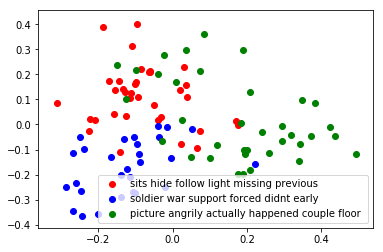

In [242]:
colors = ['red', 'blue', 'green', 'yellow', 'black', 'gray', 'orange', 'brown']
for i in range(len(cluster_names)):
    plt.scatter(transformed[labels == i][0], transformed[labels == i][1], label=cluster_names[i], c=colors[i])
plt.legend()
plt.show()

# And you're done!